In [1]:
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn

import ipdb

# TCA Part

In [2]:
def var_name(var, all_var=locals()):
    return [var_name for var_name in all_var if all_var[var_name] is var][0]

In [3]:
def np2csv(A):
    if type(A) == torch.Tensor:
        np.savetxt(var_name(A)+'.csv', A.detach().numpy(), delimiter=',')
    elif type(A) == np.ndarray:
        np.savetxt(var_name(A)+'.csv', A, delimiter=',')

In [4]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            # next line: K = X1.T@X2
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = X1.T@X1
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K

In [5]:
class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        L = e * e.T
        L = L / np.linalg.norm(L, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))  # page 202
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, L, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Z /= np.linalg.norm(Z, axis=0)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new, A

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        return acc, y_pred, Xs_new, Xt_new

In [6]:
def normalize(V):
    return ( V - min(V.flatten()) ) / ( max(V.flatten()) - min(V.flatten()) )

In [7]:
def sliding_window(T, seq_len, label_seq_len, inp_dim=1, label_dim=1):

    # inp_dim is equal to window_size
    # T (np.array) has dim: population, seq_len (window length)
    TT = T.reshape(-1, 1)
    K = TT.shape[0] - seq_len - label_seq_len + 1

    # TT has dim: n, 1
    # assemble the data into 2D
    train_x = np.vstack(TT[i : K+i, 0] for i in range(seq_len)).T
    train_y = np.vstack(TT[i+inp_dim : K+inp_dim+i, 0] for i in range(label_seq_len)).T
    
    assert train_x.shape[0] == train_y.shape[0]

    # return size: [sequence_len, batch_size, inp/out dim = 1(default)]
    return train_x.T, train_y.T


## Input "seq_len", "inp_dim", "label_dim" below

In [8]:
data_source = np.array(pd.read_csv('site8700_1_20210101_20210131.csv'))  # leeds
data_target = np.array(pd.read_csv('siteM4_2210B_20210101_20210131.csv'))  # london

src_domain = data_source
date_choosen = 12
tar_domain = data_target[date_choosen, :].reshape(-1, 96)
tgt_validation = data_target[date_choosen:date_choosen+10, :].reshape(-1, 96)

src_domain = normalize(src_domain)
tar_domain = normalize(tar_domain)

# source_x and source_y would be used for training the network
inp_dim = 1
label_dim = 1
label_seq_len = 1
# batch_size = full batch
seq_len = 6
target_x, target_y = sliding_window(tar_domain, seq_len, label_seq_len)
source_x, source_y = sliding_window(src_domain, seq_len, label_seq_len)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


In [9]:
print(source_x.shape)
print(source_y.shape)
print(target_x.shape)
print(target_y.shape)

(6, 2778)
(1, 2778)
(6, 90)
(1, 90)


In [10]:

reduced_de = 1
seq_len -= reduced_de

tca = TCA(kernel_type='linear', dim=seq_len, lamb=3, gamma=1)
Xs_new, Xt_new, A = tca.fit(source_x.T, target_x.T)
Xs_new, Xt_new = Xs_new.T, Xt_new.T

train_x = np.concatenate((Xs_new, Xt_new), axis=1)
train_y = np.concatenate((source_y, target_y), axis=1)
target_x = Xt_new


# Learning Part

In [11]:
print(train_x.shape)
print(train_y.shape)

(5, 2868)
(1, 2868)


In [12]:
class LSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dim, layers):
        super(LSTM, self).__init__()

        self.out_dim = out_dim
        
        self.lstm = nn.LSTM(inp_dim, hid_dim, layers, dropout=0.1)
        
        self.fc = nn.Sequential(
            nn.Linear(hid_dim, out_dim)
        )  # regression
    
    def forward(self, x):
        # input: (seq_len, batchsize, input_size)
        # output: (seq_len, batchsize, hid_dim)
        #ipdb.set_trace()
        y = self.lstm(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        
        y = y.view(-1, hid_dim)
        y = self.fc(y)  # fully connected layer
        y = y.view(seq_len, batch_size, -1)
        assert y.shape[2] == self.out_dim
        
        return y[0, :, :]


In [13]:
def assemble(X):
    '''
    X = torch.tensor(X)
    batch_num = X.shape[0] // (seq_len*batch_size)
    new_X = torch.zeros(seq_len, batch_size, dim, batch_num)
    for i in range(batch_num):
        for j in range(batch_size):
            #ipdb.set_trace()
            new_X[:, j, :, i] = X[seq_len*(i*j+j):seq_len*(i*j+j+1), :]
    '''
    new_X = X[:, :, np.newaxis]
    return new_X


## Input "hid_dim", "layers" below

In [14]:
# build model
hid_dim, layers = 4, 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LSTM(inp_dim, label_dim, hid_dim, layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)

train_x = assemble(train_x)
train_y = assemble(train_y)
target_x = assemble(target_x)
target_y = assemble(target_y)

train_x = torch.tensor(train_x, dtype=torch.float32, device=device)
train_y = torch.tensor(train_y, dtype=torch.float32, device=device)
target_x = torch.tensor(target_x, dtype=torch.float32, device=device)
target_y = torch.tensor(target_y, dtype=torch.float32, device=device)

In [20]:
# train
num_epoch = 2501

for e in range(num_epoch):
    # train_x: [seq_len, batch_size, inp_dim, batch#]
    #ipdb.set_trace()
    out = net(train_x)

    loss = (out - train_y) ** 2
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    
    if e%100==0:
        print('Epoch: {:4}, Loss: {:.7f}'.format(e, loss.item()))
        #scheduler.step()
        # test

        '''
        fig = plt.figure(figsize=[20, 5])
        pred_y = out.T.detach().numpy().reshape(-1,1)
        ground_truth = train_y[:, :, :, i].T.reshape(-1,1)
        ground_truth = normalize(ground_truth)
        ax1 = fig.add_subplot(121)
        ax1.plot(ground_truth, 'r', label='true value')
        ax1.plot(pred_y, 'b', label='predict')
        ax1.legend()
        
        
        ax2 = fig.add_subplot(122)
        ax2.plot(ground_truth, 'r', label='true value')
        ax2.plot(pred_y, 'b', label='predict')
        ax2.legend()
        plt.show()
        '''

Epoch:    0, Loss: 0.0369336
Epoch:  100, Loss: 0.0364612
Epoch:  200, Loss: 0.0370224
Epoch:  300, Loss: 0.0371510
Epoch:  400, Loss: 0.0364113
Epoch:  500, Loss: 0.0364539
Epoch:  600, Loss: 0.0366459
Epoch:  700, Loss: 0.0362437
Epoch:  800, Loss: 0.0362513
Epoch:  900, Loss: 0.0364065
Epoch: 1000, Loss: 0.0365547
Epoch: 1100, Loss: 0.0357714
Epoch: 1200, Loss: 0.0363992
Epoch: 1300, Loss: 0.0365834
Epoch: 1400, Loss: 0.0361155
Epoch: 1500, Loss: 0.0369454
Epoch: 1600, Loss: 0.0363940
Epoch: 1700, Loss: 0.0360820
Epoch: 1800, Loss: 0.0361003
Epoch: 1900, Loss: 0.0359319
Epoch: 2000, Loss: 0.0360018
Epoch: 2100, Loss: 0.0358362
Epoch: 2200, Loss: 0.0355902
Epoch: 2300, Loss: 0.0355749
Epoch: 2400, Loss: 0.0357538
Epoch: 2500, Loss: 0.0357447


In [21]:
train_y.shape

torch.Size([1, 2868, 1])

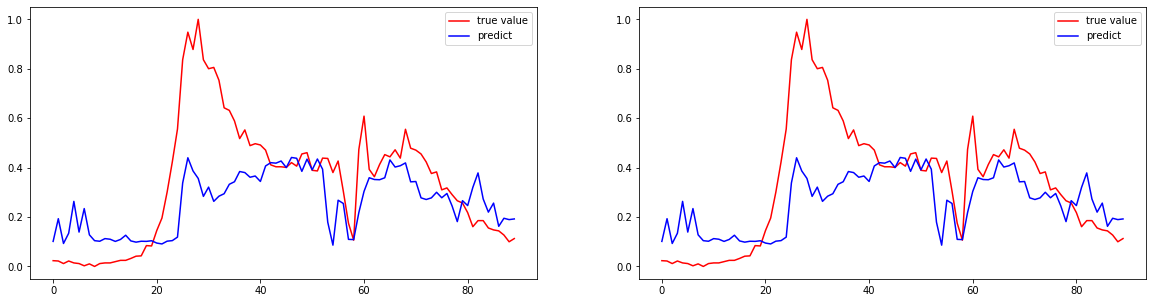

In [22]:
# test
num_day = 3

pred_y = net(target_x).detach().numpy().T.flatten()
ground_truth = target_y.detach().numpy().T.flatten()

fig = plt.figure(figsize=[20, 5])
ax1 = fig.add_subplot(121)
ax1.plot(ground_truth[:97*num_day], 'r', label='true value')
ax1.plot(pred_y[:97*num_day], 'b', label='predict')
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(ground_truth, 'r', label='true value')
ax2.plot(pred_y, 'b', label='predict')
ax2.legend()
plt.show()

In [23]:
train_x_temp = train_x.reshape(-1, seq_len)
np2csv(train_x_temp)
target_x_temp = target_x.reshape(-1, seq_len)
np2csv(target_x_temp)
#np2csv(A)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


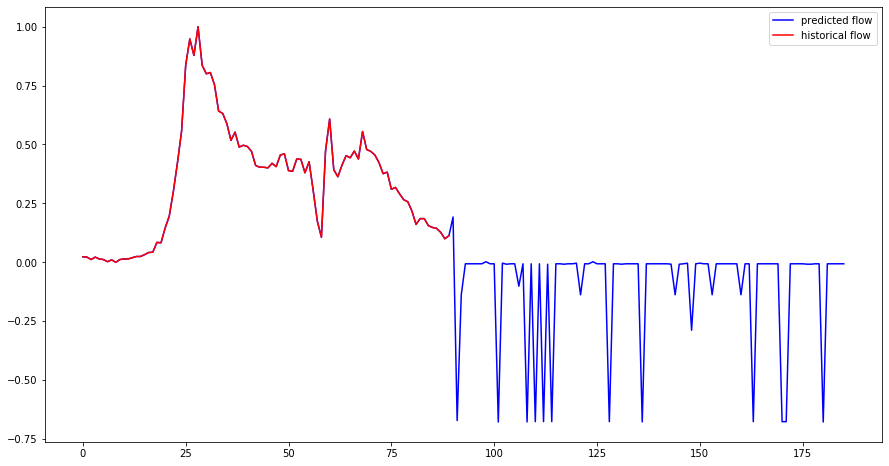

In [24]:
new_target_x = target_x.detach().numpy().copy()
new_target_x = torch.tensor(new_target_x, dtype=torch.float32, device=device)
target_y_plot = list(target_y.detach().numpy().copy().T.flatten())

for i in range(96):
    pred_y = net(new_target_x).detach().numpy()
    #ipdb.set_trace()
    target_y_plot.append(pred_y[-1][0])
    new_tar_domain = np.hstack([tar_domain[0:1, 1:], pred_y.reshape(1, -1)])
    new_target_x, new_target_y = sliding_window(new_tar_domain, seq_len, label_seq_len)
    new_target_x = torch.tensor(new_target_x, dtype=torch.float32, device=device)
    # new_target_x = A@new_target_x
    new_target_x = new_target_x.reshape(seq_len, -1, inp_dim)


fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111)
ax.plot(target_y_plot, 'b', label='predicted flow')
ax.plot(target_y.detach().numpy().T.flatten(), 'r', label='historical flow')
plt.legend()